# 13__motif_chip_tf_ts_redo
# testing whether gene tissue-sp correlates with chip/motif tissue-sp

after talking to lucas: find tissue-sp for each TF, find all genes that have that motif/chip peak, calc. average tissue-sp. of those genes, correlate that with the tissue-sp. (and subset by class, if needed)

run outside of notebook:
    ````bedtools intersect -wo -a ../../data/00__index/0__all_tss/TSS.start.1perGencGene.geneIdOnly.3kb.bed -b ../../misc/07__chip/ALL_CELL_LINES__all_ChIP_peaks.bed````
also for enhancers

took fimo mappings from marta's directory

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import time

from os import walk
from scipy.stats import spearmanr

# import utils
sys.path.append("../../utils")
from plotting_utils import *
from misc_utils import *
from norm_utils import *

%matplotlib inline

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

## variables

In [3]:
chip_f = "chip_all.txt"

In [4]:
fimo_f = "fimo_all_biotypes.txt"

In [5]:
tss_ts_f = "hg19.cage_peak_phase1and2combined_counts.osc.tissue_specificity.txt"
enh_ts_f = "human_permissive_enhancers_phase_1_and_2_expression_count_matrix.tissue_specificity.txt"

In [6]:
annot_f = "../../misc/00__tss_properties/TSS_FantomCat_all.TSSperENSG.txt"
fimo_map_f = "../../misc/04__jaspar_id_map/2018_03_09_gencode_jaspar_curated.txt"
chip_map_f = "ensembl_92_gene_id_to_name.txt"

In [7]:
tf_ts_f = "gtex_tissue_specificity_tau.txt"

## 1. import data

In [8]:
fimo = pd.read_table(fimo_f, sep="\t")
fimo = fimo[fimo["shuffled"] != "shuffled"]
fimo.head()

,#pattern name,short_description,tss_id,shuffled,start,stop,strand,score,p-value,q-value,matched sequence,motif_id,biotype
2533673,RUNX1,p1@SYVN1,"chr11:64901978..64902009,-",NaN,15,25,+,15.6034,2.490000e-07,0.338,gtctgtggttt,RUNX1,protein_coding
2533674,RUNX1,NaN,"chr2:66610364..66610365,+",NaN,13,23,-,15.6034,2.490000e-07,0.338,GTCTGTGGTTT,RUNX1,intergenic
2533675,RUNX1,NaN,"chr6:29424953..29424961,+",NaN,47,57,-,15.6034,2.490000e-07,0.338,GTCTGTGGTTT,RUNX1,protein_coding
2533676,RUNX1,p1@ENST00000412759,"chr1:120838328..120838358,-",NaN,169,179,-,15.6034,2.490000e-07,0.338,GTCTGTGGTTT,RUNX1,div_lnc
2533677,RUNX1,p1@TXNDC11,"chr16:11836595..11836726,-",NaN,235,245,-,15.6034,2.490000e-07,0.338,GTCTGTGGTTT,RUNX1,div_pc


In [9]:
chip = pd.read_table(chip_f, sep="\t")
chip.head()

,chromosome,start,end,short_description,tss_id,score,strand,chip_id,chip_chromosome,chip_start,chip_end,chip_score,biotype,pos,pos_rel,motif_id
0,chr1,10002385,10005385,p1@LZIC,"chr1:10003372..10003465,-",0,-,ARID3A,chr1,10003524,10003525,24.543343,div_pc,10003524.5,-139.5,ARID3A
1,chr1,10002385,10005385,p1@LZIC,"chr1:10003372..10003465,-",0,-,ATF2,chr1,10003413,10003414,42.461327,div_pc,10003413.5,-28.5,ATF2
2,chr1,10002385,10005385,p1@LZIC,"chr1:10003372..10003465,-",0,-,ATF2,chr1,10003497,10003498,69.683125,div_pc,10003497.5,-112.5,ATF2
3,chr1,10002385,10005385,p1@LZIC,"chr1:10003372..10003465,-",0,-,ATF3,chr1,10003457,10003458,27.073183,div_pc,10003457.5,-72.5,ATF3
4,chr1,10002385,10005385,p1@LZIC,"chr1:10003372..10003465,-",0,-,BCL3,chr1,10003424,10003425,55.235219,div_pc,10003424.5,-39.5,BCL3


In [10]:
tss_ts = pd.read_table(tss_ts_f, sep="\t")
tss_ts.head()

,tss_id,tissue_spec
0,01STAT:MAPPED,0.087543
1,"chr10:100013403..100013414,-",0.980206
2,"chr10:100027943..100027958,-",0.782627
3,"chr10:100076685..100076699,+",0.978467
4,"chr10:100150910..100150935,-",0.970738


In [11]:
enh_ts = pd.read_table(enh_ts_f, sep="\t")
enh_ts.head()

,tss_id,tissue_spec
0,chr1:839741-840250,0.974827
1,chr1:840753-841210,0.967327
2,chr1:845485-845678,0.966489
3,chr1:855764-856157,0.982428
4,chr1:856539-856757,0.976588


In [12]:
all_ts = tss_ts.append(enh_ts)

In [13]:
annot = pd.read_table(annot_f, sep="\t")
promtype2 = annot[["gene_id", "PromType2"]].drop_duplicates()
promtype2.head()

,gene_id,PromType2
0,ENSG00000000003.10,protein_coding
8,ENSG00000000005.5,protein_coding
13,ENSG00000000419.8,protein_coding
17,ENSG00000000457.9,protein_coding
24,ENSG00000000460.12,protein_coding


In [14]:
fimo_map = pd.read_table(fimo_map_f, sep="\t")
fimo_map.head()

,motif_id,motif_name,Gene ID,comment
0,MA0002.2,RUNX1,ENSG00000159216,NaN
1,MA0003.3,TFAP2A,ENSG00000137203,NaN
2,MA0007.3,Ar,ENSG00000169083,Mus musculus; human ortholog selected
3,MA0009.2,T,ENSG00000164458,NaN
4,MA0014.2,PAX5,ENSG00000196092,NaN


In [15]:
chip_map = pd.read_table(chip_map_f, sep="\t")
chip_map.head()

,Gene stable ID,Gene name
0,ENSG00000276626,RF00100
1,ENSG00000201317,RNU4-59P
2,ENSG00000200823,SNORD114-2
3,ENSG00000221598,MIR1249
4,ENSG00000199595,RF00019


In [16]:
tf_ts = pd.read_table(tf_ts_f, sep="\t")
tf_ts.head()

,GeneID,tissue_spec,tissue_spec_tau
0,ENSG00000223972.4,0.589677,0.986427
1,ENSG00000227232.4,0.203154,0.225353
2,ENSG00000243485.2,NaN,NaN
3,ENSG00000237613.2,NaN,NaN
4,ENSG00000268020.2,NaN,NaN


## 2. grab gene_ids for motif_names in chip/fimo 

In [17]:
fimo_tfs = list(fimo["motif_id"].unique())
len(fimo_tfs)

435

In [18]:
chip_tfs = list(chip["motif_id"].unique())
len(chip_tfs)

160

In [19]:
manual_aliases = {"SIN3AK20": "SIN3A", "KAP1": "TRIM28", "SREBP1": "SREBF1", "ZZZ3": "AC118549.1", 
                  "RPC155": "POLR3A", "RDBP": "NELFE", "FAM48A": "SUPT20H", "MZF1(VAR.2)": "MZF1",
                  "RORA(VAR.2)": "RORA", "JUN(VAR.2)": "JUN", "JUND(VAR.2)": "JUND", "NKX2-5(VAR.2)": "NKX2-5",
                  "JDP2(VAR.2)": "JDP2", "NR2F6(VAR.2)": "NR2F6", "RARA(VAR.2)": "RARA", "TFAP2A(VAR.2)": "TFAP2A",
                  "TFAP2B(VAR.2)": "TFAP2B", "TFAP2B(VAR.3)": "TFAP2B", "TFAP2C(VAR.2)": "TFAP2C", 
                  "SREBF2(VAR.2)": "SREBF2", "SREBF1(VAR.2)": "SREBF1", "RARB(VAR.2)": "RARB", 
                  "RARG(VAR.2)": "RARG", "TFAP2A(VAR.3)": "TFAP2A", "TFAP2C(VAR.3)": "TFAP2C", "MIX-A": "MIXL1"}
manual_gene_ids = {"HSF1": "ENSG00000185122", "HNF1B": "ENSG00000275410", "KLF13": "ENSG00000169926",
                   "POU5F1": "ENSG00000204531", "SMARCB1": "ENSG00000099956", "RXRB": "ENSG00000204231"}

In [20]:
def get_gene_id(motif_names, fimo_map, chip_map, manual_aliases, manual_gene_ids):
    gene_id_map = {}
    for motif in motif_names:
        motif = motif.upper()
        
        if "::" in motif:
            # fusion protein, continue
            gene_id_map[motif] = np.nan
            continue
        
        if motif in manual_gene_ids:
            gene_id_map[motif] = manual_gene_ids[motif]
            continue
            
        try:
            fimo_id = fimo_map[fimo_map["motif_name"] == motif]["Gene ID"].iloc[0]
        except:
            fimo_id = "none"
        try:
            chip_id = chip_map[chip_map["Gene name"] == motif]["Gene stable ID"].iloc[0]
        except:
            chip_id = "none"
        if fimo_id == "none" and chip_id == "none":
            try:
                alias = manual_aliases[motif]
            except:
                print("%s: no id, no alias" % motif)
                gene_id_map[motif] = np.nan
                continue
            try:
                real_id = chip_map[chip_map["Gene name"] == alias]["Gene stable ID"].iloc[0]
            except:
                print("%s: no id found for alias %s" % (motif, alias))
                gene_id_map[motif] = np.nan
        elif fimo_id != "none" and chip_id == "none":
            #print("found fimo id")
            gene_id_map[motif] = fimo_id
        elif fimo_id == "none" and chip_id != "none":
            #print("found chip id")
            gene_id_map[motif] = chip_id
        elif fimo_id != "none" and chip_id != "none":
            if fimo_id == chip_id:
                #print("found fimo/chip id that agrees")
                gene_id_map[motif] = fimo_id
            else:
                #print("%s: found fimo/chip id that disagree: %s, %s\n" % (motif, fimo_id, chip_id))
                real_id = manual_gene_ids[motif]
                gene_id_map[motif] = real_id
    return gene_id_map

In [21]:
chip_id_map = get_gene_id(chip_tfs, fimo_map, chip_map, manual_aliases, manual_gene_ids)

GRP20: no id, no alias


In [22]:
fimo_id_map = get_gene_id(fimo_tfs, fimo_map, chip_map, manual_aliases, manual_gene_ids)

RHOX11: no id, no alias


In [23]:
chip_id_map = pd.DataFrame.from_dict(chip_id_map, orient="index").reset_index()
chip_id_map.columns = ["motif_name", "gene_id"]
chip_id_map.head()

,motif_name,gene_id
0,ARID3A,ENSG00000116017
1,ATF2,ENSG00000115966
2,ATF3,ENSG00000162772
3,BCL3,ENSG00000069399
4,BCLAF1,ENSG00000029363


In [24]:
fimo_id_map = pd.DataFrame.from_dict(fimo_id_map, orient="index").reset_index()
fimo_id_map.columns = ["motif_name", "gene_id"]
fimo_id_map.head()

,motif_name,gene_id
0,RUNX1,ENSG00000159216
1,TFAP2A,ENSG00000137203
2,AR,ENSG00000169083
3,T,ENSG00000164458
4,PAX5,ENSG00000196092


## 3. merge fimo/chip with tss tissue-sp values
why are some TSSs missing?

In [25]:
len(fimo)

4455254

In [26]:
fimo_ts = fimo.merge(all_ts, on="tss_id")
print(len(fimo_ts))
fimo_ts.sample(5)

4022690


,#pattern name,short_description,tss_id,shuffled,start,stop,strand,score,p-value,q-value,matched sequence,motif_id,biotype,tissue_spec
790880,KLF5,p2@CDC45,"chr22:19466980..19467003,+",NaN,2774,2783,-,16.2857,0.000001,0.015,GCCCCGCCCT,KLF5,protein_coding,0.963875
2972599,TFEC,NaN,chr8:2418829-2418999,NaN,2984,2993,+,13.9146,0.000005,1.000,agcacgtgac,TFEC,enhancer,0.974603
3648603,HOXA10,NaN,chr7:86609428-86609776,NaN,1717,1727,+,13.5660,0.000001,0.505,ggtaataaaac,HOXA10,enhancer,0.993728
85864,RUNX1,p7@PLD1,"chr3:171529110..171529141,-",NaN,612,622,+,13.6724,0.000007,0.401,TTCTGTGGTCT,RUNX1,protein_coding,0.975843
2099405,SREBF2(var.2),NaN,chr20:40321359-40321668,NaN,1976,1985,-,16.8545,0.000003,1.000,GTCACGTGAC,SREBF2(var.2),enhancer,0.923712


In [27]:
missing_tss_ids_fimo = fimo[~fimo["tss_id"].isin(fimo_ts["tss_id"])]["tss_id"].unique()
len(missing_tss_ids_fimo)

7619

In [28]:
len(chip)

5940131

In [29]:
chip_ts = chip.merge(all_ts, on="tss_id")
print(len(chip_ts))
chip_ts.sample(5)

5293069


,chromosome,start,end,short_description,tss_id,score,strand,chip_id,chip_chromosome,chip_start,chip_end,chip_score,biotype,pos,pos_rel,motif_id,tissue_spec
3099756,chr10,3850734,3853734,NaN,chr10:3852273-3852886,0,+,ZBTB7A,chr10,3851854,3851855,22.160684,enhancer,3851854.5,-879.5,ZBTB7A,0.955008
601120,chr12,120970158,120973158,p1@RNF10,"chr12:120972147..120972167,+",0,+,POLR2A,chr12,120972187,120972188,97.088955,protein_coding,120972187.5,29.5,POLR2A,0.234204
820742,chr14,64193773,64196773,p1@SGPP1,"chr14:64194745..64194799,-",0,-,TCF7L2,chr14,64194964,64194965,80.010361,protein_coding,64194964.5,-191.5,TCF7L2,0.420277
800343,chr14,36788807,36791807,p1@MBIP,"chr14:36789789..36789860,-",0,-,POLR2A,chr14,36789791,36789792,90.643676,protein_coding,36789791.5,15.5,POLR2A,0.483707
2313692,chr6,31512627,31515627,p4@NFKBIL1,"chr6:31514622..31514641,+",0,+,RELA,chr6,31515256,31515257,46.954125,protein_coding,31515256.5,629.5,RELA,0.789795


In [30]:
missing_tss_ids_chip = chip[~chip["tss_id"].isin(chip_ts["tss_id"])]["tss_id"].unique()
len(missing_tss_ids_chip)

6469

## 4. find tissue-sp per TF
#### use gtex for now

In [31]:
tf_ts["gene_id"] = tf_ts["GeneID"].str.split(".", expand=True)[0]
tf_ts.head()

,GeneID,tissue_spec,tissue_spec_tau,gene_id
0,ENSG00000223972.4,0.589677,0.986427,ENSG00000223972
1,ENSG00000227232.4,0.203154,0.225353,ENSG00000227232
2,ENSG00000243485.2,NaN,NaN,ENSG00000243485
3,ENSG00000237613.2,NaN,NaN,ENSG00000237613
4,ENSG00000268020.2,NaN,NaN,ENSG00000268020


In [32]:
chip_id_map_ts = chip_id_map.merge(tf_ts, on="gene_id", how="left")
chip_id_map_ts.sample(5)

,motif_name,gene_id,GeneID,tissue_spec,tissue_spec_tau
148,BDP1,ENSG00000145734,ENSG00000145734.14,0.206479,0.308354
126,EZH2,ENSG00000106462,ENSG00000106462.6,0.246927,0.729700
77,SP1,ENSG00000185591,ENSG00000185591.5,0.203233,0.227516
12,CREB1,ENSG00000118260,ENSG00000118260.10,0.206613,0.311374
150,BRF2,ENSG00000104221,ENSG00000104221.8,0.206340,0.305182


In [33]:
chip_id_map_ts[pd.isnull(chip_id_map_ts["tissue_spec"])]

,motif_name,gene_id,GeneID,tissue_spec,tissue_spec_tau
127,GRP20,NaN,NaN,NaN,NaN


In [34]:
fimo_id_map_ts = fimo_id_map.merge(tf_ts, on="gene_id", how="left")
fimo_id_map_ts.sample(5)

,motif_name,gene_id,GeneID,tissue_spec,tissue_spec_tau
191,ALX3,ENSG00000156150,ENSG00000156150.6,0.352883,0.923747
320,POU5F1B,ENSG00000212993,ENSG00000212993.3,0.240622,0.697340
347,TCF21,ENSG00000118526,ENSG00000118526.6,0.252364,0.753331
44,ZNF143,ENSG00000166478,ENSG00000166478.5,0.203062,0.222797
380,HOXD12,ENSG00000170178,ENSG00000170178.5,0.431913,0.959631


In [35]:
fimo_id_map_ts[pd.isnull(fimo_id_map_ts["tissue_spec"])]

,motif_name,gene_id,GeneID,tissue_spec,tissue_spec_tau
6,DDIT3::CEBPA,NaN,NaN,NaN,NaN
27,MAX::MYC,NaN,NaN,NaN,NaN
30,PPARG::RXRA,NaN,NaN,NaN,NaN
36,RXRA::VDR,NaN,NaN,NaN,NaN
46,TAL1::TCF3,NaN,NaN,NaN,NaN
47,HAND1::TCF3,NaN,NaN,NaN,NaN
65,NR1H2::RXRA,NaN,NaN,NaN,NaN
68,NFIC::TLX1,NaN,NaN,NaN,NaN
77,GATA1::TAL1,NaN,NaN,NaN,NaN
79,POU5F1::SOX2,NaN,NaN,NaN,NaN


## 5. merge fimo/chip with tf spec values

In [37]:
chip_ts["motif_upper"] = chip_ts["motif_id"].str.upper()
chip_ts.head()

,chromosome,start,end,short_description,tss_id,score,strand,chip_id,chip_chromosome,chip_start,chip_end,chip_score,biotype,pos,pos_rel,motif_id,tissue_spec,motif_upper
0,chr1,10002385,10005385,p1@LZIC,"chr1:10003372..10003465,-",0,-,ARID3A,chr1,10003524,10003525,24.543343,div_pc,10003524.5,-139.5,ARID3A,0.3734,ARID3A
1,chr1,10002385,10005385,p1@LZIC,"chr1:10003372..10003465,-",0,-,ATF2,chr1,10003413,10003414,42.461327,div_pc,10003413.5,-28.5,ATF2,0.3734,ATF2
2,chr1,10002385,10005385,p1@LZIC,"chr1:10003372..10003465,-",0,-,ATF2,chr1,10003497,10003498,69.683125,div_pc,10003497.5,-112.5,ATF2,0.3734,ATF2
3,chr1,10002385,10005385,p1@LZIC,"chr1:10003372..10003465,-",0,-,ATF3,chr1,10003457,10003458,27.073183,div_pc,10003457.5,-72.5,ATF3,0.3734,ATF3
4,chr1,10002385,10005385,p1@LZIC,"chr1:10003372..10003465,-",0,-,BCL3,chr1,10003424,10003425,55.235219,div_pc,10003424.5,-39.5,BCL3,0.3734,BCL3


In [38]:
chip_ts = chip_ts.merge(chip_id_map_ts, left_on="motif_upper", right_on="motif_name", how="left")
chip_ts.head()

,chromosome,start,end,short_description,tss_id,score,strand,chip_id,chip_chromosome,chip_start,...,pos,pos_rel,motif_id,tissue_spec_x,motif_upper,motif_name,gene_id,GeneID,tissue_spec_y,tissue_spec_tau
0,chr1,10002385,10005385,p1@LZIC,"chr1:10003372..10003465,-",0,-,ARID3A,chr1,10003524,...,10003524.5,-139.5,ARID3A,0.3734,ARID3A,ARID3A,ENSG00000116017,ENSG00000116017.6,0.243316,0.711899
1,chr1,10002385,10005385,p1@LZIC,"chr1:10003372..10003465,-",0,-,ATF2,chr1,10003413,...,10003413.5,-28.5,ATF2,0.3734,ATF2,ATF2,ENSG00000115966,ENSG00000115966.12,0.204556,0.262339
2,chr1,10002385,10005385,p1@LZIC,"chr1:10003372..10003465,-",0,-,ATF2,chr1,10003497,...,10003497.5,-112.5,ATF2,0.3734,ATF2,ATF2,ENSG00000115966,ENSG00000115966.12,0.204556,0.262339
3,chr1,10002385,10005385,p1@LZIC,"chr1:10003372..10003465,-",0,-,ATF3,chr1,10003457,...,10003457.5,-72.5,ATF3,0.3734,ATF3,ATF3,ENSG00000162772,ENSG00000162772.12,0.216412,0.483653
4,chr1,10002385,10005385,p1@LZIC,"chr1:10003372..10003465,-",0,-,BCL3,chr1,10003424,...,10003424.5,-39.5,BCL3,0.3734,BCL3,BCL3,ENSG00000069399,ENSG00000069399.8,0.211082,0.400526


In [39]:
fimo_ts["motif_upper"] = fimo_ts["motif_id"].str.upper()
fimo_ts.head()

,#pattern name,short_description,tss_id,shuffled,start,stop,strand,score,p-value,q-value,matched sequence,motif_id,biotype,tissue_spec,motif_upper
0,RUNX1,p1@SYVN1,"chr11:64901978..64902009,-",NaN,15,25,+,15.6034,2.490000e-07,0.338,gtctgtggttt,RUNX1,protein_coding,0.349684,RUNX1
1,TFAP2A,p1@SYVN1,"chr11:64901978..64902009,-",NaN,1604,1614,+,13.8909,9.460000e-06,0.155,CCCCTCAGGCT,TFAP2A,protein_coding,0.349684,TFAP2A
2,PAX5,p1@SYVN1,"chr11:64901978..64902009,-",NaN,638,656,+,14.5484,5.460000e-06,0.107,ctgggcgacagagcaagac,PAX5,protein_coding,0.349684,PAX5
3,E2F1,p1@SYVN1,"chr11:64901978..64902009,-",NaN,616,627,+,14.1475,8.620000e-06,1.000,gatggcgccaat,E2F1,protein_coding,0.349684,E2F1
4,ELK1,p1@SYVN1,"chr11:64901978..64902009,-",NaN,1947,1956,+,16.2128,3.920000e-06,0.605,gccggAAGTG,ELK1,protein_coding,0.349684,ELK1


In [40]:
fimo_ts = fimo_ts.merge(fimo_id_map_ts, left_on="motif_upper", right_on="motif_name", how="left")
fimo_ts.head()

,#pattern name,short_description,tss_id,shuffled,start,stop,strand,score,p-value,q-value,matched sequence,motif_id,biotype,tissue_spec_x,motif_upper,motif_name,gene_id,GeneID,tissue_spec_y,tissue_spec_tau
0,RUNX1,p1@SYVN1,"chr11:64901978..64902009,-",NaN,15,25,+,15.6034,2.490000e-07,0.338,gtctgtggttt,RUNX1,protein_coding,0.349684,RUNX1,RUNX1,ENSG00000159216,ENSG00000159216.14,0.235779,0.667911
1,TFAP2A,p1@SYVN1,"chr11:64901978..64902009,-",NaN,1604,1614,+,13.8909,9.460000e-06,0.155,CCCCTCAGGCT,TFAP2A,protein_coding,0.349684,TFAP2A,TFAP2A,ENSG00000137203,ENSG00000137203.6,0.301559,0.872627
2,PAX5,p1@SYVN1,"chr11:64901978..64902009,-",NaN,638,656,+,14.5484,5.460000e-06,0.107,ctgggcgacagagcaagac,PAX5,protein_coding,0.349684,PAX5,PAX5,ENSG00000196092,ENSG00000196092.8,0.505705,0.975997
3,E2F1,p1@SYVN1,"chr11:64901978..64902009,-",NaN,616,627,+,14.1475,8.620000e-06,1.000,gatggcgccaat,E2F1,protein_coding,0.349684,E2F1,E2F1,ENSG00000101412,ENSG00000101412.9,0.234943,0.662354
4,ELK1,p1@SYVN1,"chr11:64901978..64902009,-",NaN,1947,1956,+,16.2128,3.920000e-06,0.605,gccggAAGTG,ELK1,protein_coding,0.349684,ELK1,ELK1,ENSG00000126767,ENSG00000126767.13,0.206946,0.318789


## 6. find avg. tissue-spec for genes containing a given chip peak/motif

In [60]:
chip_grp = chip_ts.groupby(["motif_id", "tissue_spec_tau"])["tissue_spec_x"].agg(["mean", "count"]).reset_index()
chip_grp.columns = ["motif_id", "tf_ts", "tss_ts", "tss_count"]
chip_grp.head()

,motif_id,tf_ts,tss_ts,tss_count
0,ARID3A,0.711899,0.822828,10119
1,ATF1,0.287917,0.763838,8882
2,ATF2,0.262339,0.811896,17871
3,ATF3,0.483653,0.716232,23784
4,BACH1,0.345260,0.763086,8477


In [61]:
len(chip_grp)

152

In [62]:
fimo_grp = fimo_ts.groupby(["motif_id", "tissue_spec_tau"])["tissue_spec_x"].agg(["mean", "count"]).reset_index()
fimo_grp.columns = ["motif_id", "tf_ts", "tss_ts", "tss_count"]
fimo_grp.head()

,motif_id,tf_ts,tss_ts,tss_count
0,ALX3,0.923747,0.938096,3223
1,ATF4,0.167687,0.931278,2904
2,ATF7,0.242404,0.786313,2069
3,Alx1,0.909153,0.933308,2369
4,Alx4,0.910912,0.922418,1828


In [63]:
len(fimo_grp)

389

## 7. plot correlations

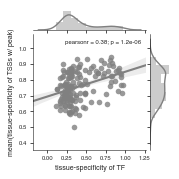

In [74]:
g = sns.jointplot(data=chip_grp, x="tf_ts", y="tss_ts", kind="reg", size=2.5, color="gray")
g.set_axis_labels("tissue-specificity of TF", "mean(tissue-specificity of TSSs w/ peak)")
g.savefig("chip_corr.pdf", dpi="figure", bbox_inches="tight")

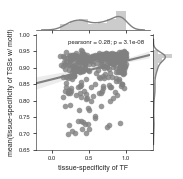

In [75]:
g = sns.jointplot(data=fimo_grp, x="tf_ts", y="tss_ts", kind="reg", size=2.5, color="gray")
g.set_axis_labels("tissue-specificity of TF", "mean(tissue-specificity of TSSs w/ motif)")
g.savefig("motif_corr.pdf", dpi="figure", bbox_inches="tight")